In [0]:
%pip install openai faiss-cpu langchain PyPDF2 chromadb pdfplumber pymupdf \
fitz langchain-openai databricks-vectorsearch langchain-cohere cohere \
plotly dash matplotlib seaborn pandas rank_bm25 scikit-learn tiktoken \
unstructured boto3 databricks-sdk transformers sentence-transformers 

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/981.5 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 34.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of opentelemetry-proto to determine which version is compatible with other requirements. This could take a while.

*** WARNING: max output size exceeded, skipping output. ***

━━━━━━━━━╸ 188.5/188.7 MB 142.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 188.5/188.7 MB 142.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 51.5 MB

In [0]:
%restart_python

In [0]:
file_path = "dbfs:/Volumes/workspace/default/processed_bills/aws_billing_data_cleaned.csv"

# Load CSV as a Spark DataFrame
df = (spark.read
      .option("header", "true")
      .option("inferSchema", "true")
      .csv(file_path))

df.createOrReplaceTempView("aws_billing")


In [0]:
monthly_cost_df = spark.sql("""
    SELECT Month, ROUND(SUM(Cost),2) AS Total_Cost
    FROM aws_billing
    GROUP BY Month
    ORDER BY Month
""")
monthly_cost_df.show()


+----------+----------+
|     Month|Total_Cost|
+----------+----------+
|2024-02-01| 355666.54|
|2024-03-01| 392347.95|
|2024-04-01| 396067.67|
|2024-05-01| 401390.63|
|2024-06-01| 369538.53|
|2024-07-01| 384861.59|
|2024-08-01| 345059.75|
|2024-09-01|  374424.1|
|2024-10-01| 380112.43|
|2024-11-01| 398421.05|
|2024-12-01| 375856.33|
|2025-01-01|  413234.9|
+----------+----------+



In [0]:
top_accounts_df = spark.sql("""
    SELECT `Account ID`, ROUND(SUM(Cost),2) AS Total_Cost
    FROM aws_billing
    GROUP BY `Account ID`
    ORDER BY Total_Cost DESC
    LIMIT 10
""")
top_accounts_df.show()

+----------+----------+
|Account ID|Total_Cost|
+----------+----------+
|   ACC0034| 133412.77|
|   ACC0023| 125706.82|
|   ACC0038| 124558.95|
|   ACC0027| 124341.07|
|   ACC0036|  123671.4|
|   ACC0028|  123423.6|
|   ACC0039| 121639.07|
|   ACC0019| 121218.26|
|   ACC0021| 119683.81|
|   ACC0012| 119642.63|
+----------+----------+



In [0]:
service_cost_df = spark.sql("""
    SELECT Service, ROUND(SUM(Cost),2) AS Total_Cost
    FROM aws_billing
    GROUP BY Service
    ORDER BY Total_Cost DESC
""")
service_cost_df.show()



+----------+----------+
|   Service|Total_Cost|
+----------+----------+
|CloudWatch| 327161.14|
|    Lambda| 315989.24|
|       EKS| 314364.61|
|  DynamoDB| 310638.14|
|       EC2| 305643.98|
|       RDS| 305459.45|
|CloudFront| 305329.18|
|       SNS| 305175.86|
|  Redshift| 304257.96|
|       SQS| 302950.36|
|      Glue| 301949.34|
|  Route 53| 299157.79|
|       VPC| 297623.96|
|       EBS| 295874.75|
|        S3| 295405.71|
+----------+----------+



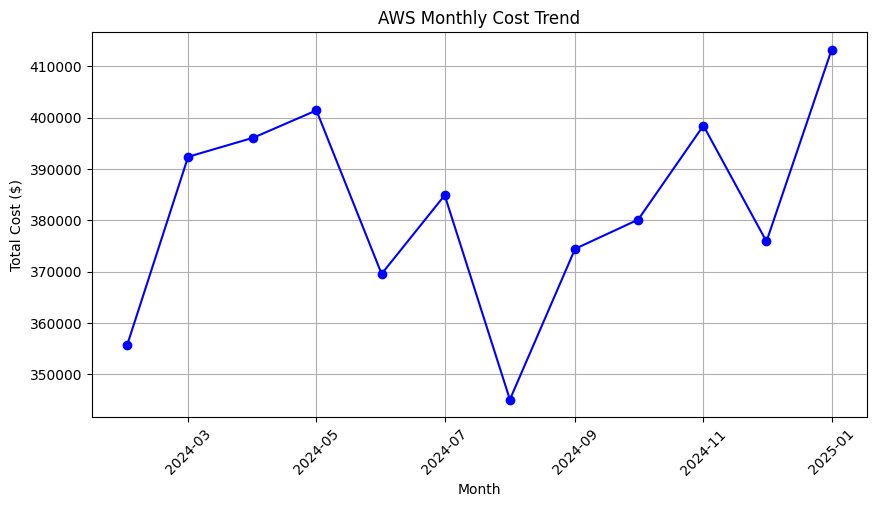

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to Pandas
monthly_pdf = monthly_cost_df.toPandas()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_pdf["Month"], monthly_pdf["Total_Cost"], marker='o', linestyle='-', color='b')
plt.xlabel("Month")
plt.ylabel("Total Cost ($)")
plt.title("AWS Monthly Cost Trend")
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [0]:
outlier_accounts_df = spark.sql("""
    WITH account_costs AS (
        SELECT `Account ID`, SUM(Cost) AS Total_Cost
        FROM aws_billing
        GROUP BY `Account ID`
    ),
    stats AS (
        SELECT AVG(Total_Cost) AS avg_cost, STDDEV(Total_Cost) AS std_dev
        FROM account_costs
    )
    SELECT a.`Account ID`, a.Total_Cost
    FROM account_costs a, stats s
    WHERE a.Total_Cost > (s.avg_cost + 2 * s.std_dev)
    ORDER BY a.Total_Cost DESC
""")
outlier_accounts_df.show()


+----------+------------------+
|Account ID|        Total_Cost|
+----------+------------------+
|   ACC0034|133412.76999999996|
+----------+------------------+



In [0]:
query = """
    WITH service_costs AS (
        SELECT `Account ID`, Month, Service, SUM(Cost) AS Total_Cost
        FROM aws_billing
        GROUP BY `Account ID`, Month, Service
    ),
    account_stats AS (
        SELECT `Account ID`, Month, 
               AVG(Total_Cost) AS avg_cost, 
               STDDEV(Total_Cost) AS std_dev
        FROM service_costs
        GROUP BY `Account ID`, Month
    )
    SELECT s.`Account ID`, s.Month, s.Service, s.Total_Cost
    FROM service_costs s
    JOIN account_stats a
    ON s.`Account ID` = a.`Account ID` AND s.Month = a.Month
    WHERE s.Total_Cost > (a.avg_cost + 2 * a.std_dev)
    ORDER BY s.`Account ID`, s.Month, s.Total_Cost DESC
"""

# Execute the query
outlier_monthly_service_costs_df = spark.sql(query)

# Display results in Databricks
display(outlier_monthly_service_costs_df)


Account ID Month Service Total_Cost ACC0001 2024-03-01 Route 53 2134.59 ACC0001 2024-05-01 CloudWatch 1672.36 ACC0001 2024-06-01 SNS 1843.84 ACC0001 2024-08-01 RDS 1599.55 ACC0001 2024-09-01 EC2 2036.21 ACC0001 2024-10-01 CloudFront 1348.16 ACC0001 2024-11-01 RDS 1903.19 ACC0001 2024-12-01 RDS 2145.04 ACC0001 2025-01-01 CloudWatch 1681.1 ACC0002 2024-03-01 VPC 1934.12 ACC0002 2024-03-01 EBS 1912.43 ACC0002 2024-06-01 SQS 1965.87 ACC0002 2024-12-01 Route 53 2133.38 ACC0002 2025-01-01 SNS 2226.22 ACC0003 2024-02-01 Route 53 1923.11 ACC0003 2024-03-01 EBS 2225.46 ACC0003 2024-05-01 CloudWatch 1950.74 ACC0003 2024-06-01 Redshift 2039.5 ACC0003 2024-07-01 EC2 1302.34 ACC0003 2024-08-01 VPC 2079.18 ACC0003 2024-09-01 Glue 1483.92 ACC0003 2024-10-01 DynamoDB 1335.28 ACC0003 2024-11-01 Lambda 2253.71 ACC0003 2024-12-01 SNS 2217.34 ACC0003 2025-01-01 Lambda 2461.65 ACC0004 2024-02-01 EKS 2158.16 ACC0004 2024-05-01 RDS 1898.47 ACC0004 2024-06-01 CloudWatch 1621.49 ACC0004 2024-07-01 Glue 2058.57 ACC0004 2024-08-01 EBS 1367.88 ACC0004 2024-11-01 Lambda 1806.65 ACC0004 2024-12-01 CloudFront 1881.81 ACC0004 2025-01-01 CloudWatch 1610.28 ACC0005 2024-02-01 EC2 1827.01 ACC0005 2024-04-01 CloudFront 1936.92 ACC0005 2024-08-01 EBS 1842.9 ACC0005 2024-09-01 RDS 1995.9 ACC0005 2025-01-01 SNS 2245.72 ACC0006 2024-02-01 SQS 1670.42 ACC0006 2024-03-01 SQS 1138.69 ACC0006 2024-04-01 RDS 2233.12 ACC0006 2024-05-01 CloudWatch 2165.68 ACC0006 2024-06-01 S3 2067.64 ACC0006 2024-08-01 EC2 1580.38 ACC0006 2024-10-01 CloudWatch 1498.22 ACC0006 2024-10-01 EBS 1427.31 ACC0006 2024-11-01 DynamoDB 2374.51 ACC0006 2024-12-01 S3 1475.86 ACC0007 2024-02-01 Route 53 1744.18 ACC0007 2024-03-01 RDS 2443.49 ACC0007 2024-04-01 DynamoDB 2062.54 ACC0007 2024-05-01 RDS 1761.4 ACC0007 2024-06-01 Route 53 1192.2 ACC0007 2024-07-01 Redshift 2257.0 ACC0007 2024-09-01 Redshift 956.0 ACC0007 2024-10-01 CloudWatch 1832.15 ACC0007 2024-12-01 SQS 1501.66 ACC0007 2025-01-01 S3 1985.19 ACC0008 2024-02-01 CloudFront 1553.68 ACC0008 2024-05-01 VPC 1662.12 ACC0008 2024-07-01 CloudWatch 2062.6 ACC0008 2024-08-01 Glue 2042.54 ACC0008 2024-09-01 EKS 2041.96 ACC0008 2024-12-01 VPC 1821.57 ACC0008 2025-01-01 EBS 1593.82 ACC0009 2024-02-01 SQS 1338.6 ACC0009 2024-03-01 EKS 2126.08 ACC0009 2024-05-01 SQS 1493.64 ACC0009 2024-06-01 CloudWatch 1369.56 ACC0009 2024-07-01 VPC 2173.21 ACC0009 2024-07-01 EKS 1852.19 ACC0009 2024-08-01 DynamoDB 1735.36 ACC0009 2024-11-01 Route 53 1598.95 ACC0009 2025-01-01 EKS 2058.87 ACC0010 2024-03-01 RDS 2418.68 ACC0010 2024-05-01 EC2 2116.14 ACC0010 2024-08-01 SNS 2018.12 ACC0010 2024-12-01 VPC 1574.72 ACC0011 2024-02-01 Redshift 1247.45 ACC0011 2024-02-01 EC2 1196.29 ACC0011 2024-03-01 CloudFront 1724.12 ACC0011 2024-04-01 Glue 1823.63 ACC0011 2024-04-01 DynamoDB 1708.87 ACC0011 2024-08-01 SNS 2065.72 ACC0011 2024-10-01 EKS 1533.62 ACC0011 2025-01-01 Glue 1737.11 ACC0012 2024-02-01 CloudFront 1319.17 ACC0012 2024-03-01 S3 2160.46 ACC0012 2024-04-01 Redshift 2030.85 ACC0012 2024-05-01 DynamoDB 2414.84 ACC0012 2024-08-01 EBS 2153.63 ACC0012 2024-10-01 CloudFront 2155.78 ACC0012 2024-11-01 S3 1943.66 ACC0012 2024-12-01 VPC 1520.9 ACC0013 2024-02-01 EC2 1772.18 ACC0013 2024-04-01 EKS 1823.5 ACC0013 2024-04-01 Redshift 1716.09 ACC0013 2024-07-01 EBS 2250.32 ACC0013 2024-08-01 SQS 1134.04 ACC0013 2024-09-01 SNS 1805.62 ACC0013 2024-11-01 EKS 1876.26 ACC0013 2025-01-01 EKS 2054.01 ACC0014 2024-02-01 S3 1707.69 ACC0014 2024-04-01 Redshift 2004.14 ACC0014 2024-06-01 SNS 1865.03 ACC0014 2024-07-01 CloudFront 2123.39 ACC0014 2024-08-01 CloudFront 1304.14 ACC0014 2024-09-01 RDS 1238.74 ACC0014 2024-11-01 DynamoDB 1605.91 ACC0015 2024-02-01 DynamoDB 1117.99 ACC0015 2024-04-01 CloudFront 2124.68 ACC0015 2024-05-01 CloudFront 2257.95 ACC0015 2024-09-01 Route 53 1456.32 ACC0015 2024-10-01 EC2 1648.03 ACC0015 2025-01-01 RDS 1632.98 ACC0016 2024-02-01 EKS 1842.96 ACC0016 2024-03-01 CloudWatch 1609.18 ACC0016 2024-04-01 Redshift 2394.76 ACC0016 2024-06-01 Route 53 1614.63 ACC001

In [0]:
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss
import os

# Load sentence transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Define FAISS storage path
faiss_index_path = "/Volumes/workspace/default/rag_demo_volume/aws_cost_faiss.index"

# Select relevant fields
df_for_embedding = df.select(
    "Service", "Usage", "Cost", "CPU Utilization (%)", "Memory Usage (%)",
    "Network In (GB)", "Network Out (GB)", "Instance Hours", "Instance Type",
    "Storage Used (GB)", "Storage Class", "Object Count", "Invocation Count",
    "Execution Time (ms)", "Memory Allocation (MB)", "Query Count",
    "Active Connections", "Idle Hours", "Storage (GB)", "DB Engine",
    "Pod Count", "Node Count", "CPU Requests (%)", "Memory Requests (%)",
    "Data Transfer (GB)", "Request Count", "Read Capacity", "Write Capacity",
    "Throttling Events", "Billing Mode", "Read IOPS", "Write IOPS",
    "Snapshot Frequency", "Volume Size (GB)", "Volume Type",
    "ETL Job Runs", "Data Processed (GB)", "Query Execution Time (ms)"
).toPandas()

# Convert each row into a meaningful text representation efficiently
def format_row(row):
    return (
        f"Service: {row['Service']}, Usage: {row['Usage']}, Cost: {row['Cost']}, "
        f"CPU Utilization: {row['CPU Utilization (%)']}%, Memory Usage: {row['Memory Usage (%)']}%, "
        f"Network In: {row['Network In (GB)']} GB, Network Out: {row['Network Out (GB)']} GB, "
        f"Instance Hours: {row['Instance Hours']}, Instance Type: {row['Instance Type']}, "
        f"Storage Used: {row['Storage Used (GB)']} GB, Storage Class: {row['Storage Class']}, "
        f"Object Count: {row['Object Count']}, Invocation Count: {row['Invocation Count']}, "
        f"Execution Time: {row['Execution Time (ms)']} ms, Memory Allocation: {row['Memory Allocation (MB)']} MB, "
        f"Query Count: {row['Query Count']}, Active Connections: {row['Active Connections']}, "
        f"Idle Hours: {row['Idle Hours']}, Storage: {row['Storage (GB)']} GB, DB Engine: {row['DB Engine']}, "
        f"Pod Count: {row['Pod Count']}, Node Count: {row['Node Count']}, "
        f"CPU Requests: {row['CPU Requests (%)']}%, Memory Requests: {row['Memory Requests (%)']}%, "
        f"Data Transfer: {row['Data Transfer (GB)']} GB, Request Count: {row['Request Count']}, "
        f"Read Capacity: {row['Read Capacity']}, Write Capacity: {row['Write Capacity']}, "
        f"Throttling Events: {row['Throttling Events']}, Billing Mode: {row['Billing Mode']}, "
        f"Read IOPS: {row['Read IOPS']}, Write IOPS: {row['Write IOPS']}, "
        f"Snapshot Frequency: {row['Snapshot Frequency']}, Volume Size: {row['Volume Size (GB)']} GB, "
        f"Volume Type: {row['Volume Type']}, ETL Job Runs: {row['ETL Job Runs']}, "
        f"Data Processed: {row['Data Processed (GB)']} GB, Query Execution Time: {row['Query Execution Time (ms)']} ms"
    )

# Apply optimized text conversion
text_data = df_for_embedding.apply(format_row, axis=1).tolist()

# Generate embeddings
embeddings = np.array(model.encode(text_data))

# Store embeddings in FAISS
index = faiss.IndexFlatL2(embeddings.shape[1])  # L2 distance index
index.add(embeddings)

# Ensure the directory exists
os.makedirs(os.path.dirname(faiss_index_path), exist_ok=True)

# Save FAISS index
faiss.write_index(index, faiss_index_path)

print(f"FAISS index saved at: {faiss_index_path}")


FAISS index saved at: /Volumes/workspace/default/rag_demo_volume/aws_cost_faiss.index


In [0]:
from databricks.sdk import WorkspaceClient

w = WorkspaceClient()
w.secrets.create_scope(scope="my_secrets")


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:132)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:132)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
from databricks.sdk import WorkspaceClient

w = WorkspaceClient()

w.secrets.put_secret("my_secrets","OPENAI_API_KEY",string_value ="key")

In [0]:

w.secrets.put_secret("my_secrets","COHERE_API_KEY",string_value ="<cohere api key>")

In [0]:
import os

faiss_index_path = "/Volumes/workspace/default/rag_demo_volume/aws_cost_faiss.index"
print(f"File exists: {os.path.exists(faiss_index_path)}")


File exists: True


In [0]:
import os

faiss_index_path = "/Volumes/workspace/default/rag_demo_volume/aws_cost_faiss.index"

# Check file permissions
print(f"Readable: {os.access(faiss_index_path, os.R_OK)}")
print(f"Writable: {os.access(faiss_index_path, os.W_OK)}")


Readable: True
Writable: True


In [0]:
import faiss

faiss_index_path = "/Volumes/workspace/default/rag_demo_volume/aws_cost_faiss.index"

# Attempt to read FAISS index
try:
    index = faiss.read_index(faiss_index_path)
    print("FAISS index loaded successfully!")
    print(f"FAISS contains {index.ntotal} embeddings.")
except Exception as e:
    print(f"Error reading FAISS index: {e}")


FAISS index loaded successfully!
FAISS contains 7200 embeddings.


In [0]:
import faiss
import os
import pandas as pd
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI
import openai
from databricks.sdk import WorkspaceClient
from langchain.docstore.in_memory import InMemoryDocstore
from langchain.schema import Document
from sentence_transformers import SentenceTransformer
import numpy as np
from concurrent.futures import ThreadPoolExecutor

# Initialize Databricks workspace client
w = WorkspaceClient()

# Retrieve OpenAI API key from Databricks secrets
try:
    openai_api_key = dbutils.secrets.get(scope="my_secrets", key="OPENAI_API_KEY")
    if not openai_api_key:
        raise ValueError("OpenAI API key is empty. Ensure the secret is properly set.")
except Exception as e:
    raise ValueError("Failed to retrieve OpenAI API key. Ensure the secret is set in Databricks.")

# Define FAISS storage path for new index
faiss_index_path = "/Volumes/workspace/default/rag_demo_volume/aws_cost_text.index"

# Load dataset
file_path = "/Volumes/workspace/default/processed_bills/aws_billing_data_cleaned.csv"
df = pd.read_csv(file_path)

# Convert each row into a meaningful text representation
def format_row(row):
    return (
        f"Service: {row['Service']}, Usage: {row['Usage']}, Cost: {row['Cost']}, "
        f"CPU Utilization: {row['CPU Utilization (%)']}%, Memory Usage: {row['Memory Usage (%)']}%, "
        f"Network In: {row['Network In (GB)']} GB, Network Out: {row['Network Out (GB)']} GB, "
        f"Instance Hours: {row['Instance Hours']}, Instance Type: {row['Instance Type']}, "
        f"Storage Used: {row['Storage Used (GB)']} GB, Storage Class: {row['Storage Class']}, "
        f"Object Count: {row['Object Count']}, Invocation Count: {row['Invocation Count']}, "
        f"Execution Time: {row['Execution Time (ms)']} ms, Memory Allocation: {row['Memory Allocation (MB)']} MB, "
        f"Query Count: {row['Query Count']}, Active Connections: {row['Active Connections']}, "
        f"Idle Hours: {row['Idle Hours']}, Storage: {row['Storage (GB)']} GB, DB Engine: {row['DB Engine']}, "
        f"Data Transfer: {row['Data Transfer (GB)']} GB, Request Count: {row['Request Count']}, "
        f"Read Capacity: {row['Read Capacity']}, Write Capacity: {row['Write Capacity']}, "
        f"Throttling Events: {row['Throttling Events']}, Billing Mode: {row['Billing Mode']}, "
        f"Read IOPS: {row['Read IOPS']}, Write IOPS: {row['Write IOPS']}, "
        f"Snapshot Frequency: {row['Snapshot Frequency']}, Volume Size: {row['Volume Size (GB)']} GB, "
        f"Volume Type: {row['Volume Type']}, ETL Job Runs: {row['ETL Job Runs']}, "
        f"Data Processed: {row['Data Processed (GB)']} GB, Query Execution Time: {row['Query Execution Time (ms)']} ms"
    )

# Convert dataset to documents
documents = [Document(page_content=format_row(row)) for _, row in df.iterrows()]

# Generate embeddings in parallel
embedding_function = OpenAIEmbeddings(openai_api_key=openai_api_key)
def embed_document(doc):
    return embedding_function.embed_query(doc.page_content)

with ThreadPoolExecutor() as executor:
    embeddings = list(executor.map(embed_document, documents))

embeddings = np.array(embeddings)

# Initialize FAISS index with metadata storage
dimension = embeddings.shape[1]
index = faiss.IndexHNSWFlat(dimension, 32)
index.add(embeddings)

# Store FAISS index
faiss.write_index(index, faiss_index_path)

print("FAISS index successfully created and stored at", faiss_index_path)

FAISS index successfully created and stored at /Volumes/workspace/default/rag_demo_volume/aws_cost_text.index


In [0]:
import faiss
import os
import pandas as pd
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI
import openai
from databricks.sdk import WorkspaceClient
from langchain.docstore.in_memory import InMemoryDocstore
from langchain.schema import Document
from sentence_transformers import SentenceTransformer
import numpy as np
from concurrent.futures import ThreadPoolExecutor

# Initialize Databricks workspace client
w = WorkspaceClient()

# Retrieve OpenAI API key from Databricks secrets
try:
    openai_api_key = dbutils.secrets.get(scope="my_secrets", key="OPENAI_API_KEY")
    if not openai_api_key:
        raise ValueError("OpenAI API key is empty. Ensure the secret is properly set.")
except Exception as e:
    raise ValueError("Failed to retrieve OpenAI API key. Ensure the secret is set in Databricks.")

# Define FAISS storage path for new index
faiss_index_path = "/Volumes/workspace/default/rag_demo_volume/aws_newcost_faiss_text.index"

# Load dataset
file_path = "/Volumes/workspace/default/processed_bills/aws_billing_data_cleaned.csv"
df = pd.read_csv(file_path)

# Convert each row into a meaningful text representation
def format_row(row):
    return (
        f"Service: {row['Service']}, Usage: {row['Usage']}, Cost: {row['Cost']}, "
        f"CPU Utilization: {row['CPU Utilization (%)']}%, Memory Usage: {row['Memory Usage (%)']}%, "
        f"Network In: {row['Network In (GB)']} GB, Network Out: {row['Network Out (GB)']} GB, "
        f"Instance Hours: {row['Instance Hours']}, Instance Type: {row['Instance Type']}, "
        f"Storage Used: {row['Storage Used (GB)']} GB, Storage Class: {row['Storage Class']}, "
        f"Object Count: {row['Object Count']}, Invocation Count: {row['Invocation Count']}, "
        f"Execution Time: {row['Execution Time (ms)']} ms, Memory Allocation: {row['Memory Allocation (MB)']} MB, "
        f"Query Count: {row['Query Count']}, Active Connections: {row['Active Connections']}, "
        f"Idle Hours: {row['Idle Hours']}, Storage: {row['Storage (GB)']} GB, DB Engine: {row['DB Engine']}, "
        f"Data Transfer: {row['Data Transfer (GB)']} GB, Request Count: {row['Request Count']}, "
        f"Read Capacity: {row['Read Capacity']}, Write Capacity: {row['Write Capacity']}, "
        f"Throttling Events: {row['Throttling Events']}, Billing Mode: {row['Billing Mode']}, "
        f"Read IOPS: {row['Read IOPS']}, Write IOPS: {row['Write IOPS']}, "
        f"Snapshot Frequency: {row['Snapshot Frequency']}, Volume Size: {row['Volume Size (GB)']} GB, "
        f"Volume Type: {row['Volume Type']}, ETL Job Runs: {row['ETL Job Runs']}, "
        f"Data Processed: {row['Data Processed (GB)']} GB, Query Execution Time: {row['Query Execution Time (ms)']} ms"
    )

# Convert dataset to documents
documents = [Document(page_content=format_row(row)) for _, row in df.iterrows()]

# Generate embeddings in parallel
embedding_function = OpenAIEmbeddings(openai_api_key=openai_api_key)
def embed_document(doc):
    return embedding_function.embed_query(doc.page_content)

with ThreadPoolExecutor() as executor:
    embeddings = list(executor.map(embed_document, documents))

embeddings = np.array(embeddings)

# Initialize FAISS index with metadata storage
dimension = embeddings.shape[1]
index = faiss.IndexHNSWFlat(dimension, 32)
index.add(embeddings)

# Store FAISS index
faiss.write_index(index, faiss_index_path)

In [0]:
import pandas as pd

# Define CSV path in Databricks
file_path = "/Volumes/workspace/default/processed_bills/aws_billing_data_cleaned.csv"

# Load the CSV file
df = pd.read_csv(file_path)

# Display first few rows
display(df)


Account ID Month Service Usage Cost CPU Utilization (%) Memory Usage (%) Network In (GB) Network Out (GB) Instance Hours Instance Type Storage Used (GB) Storage Class Object Count Invocation Count Execution Time (ms) Memory Allocation (MB) Query Count Active Connections Idle Hours Storage (GB) DB Engine Pod Count Node Count CPU Requests (%) Memory Requests (%) Data Transfer (GB) Request Count Read Capacity Write Capacity Throttling Events Billing Mode Read IOPS Write IOPS Snapshot Frequency Volume Size (GB) Volume Type ETL Job Runs Data Processed (GB) Query Execution Time (ms) ACC0001 2024-02 EC2 1089.65 181.91 413.93 486.46 486.05 531.77 509.31 m5.large 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 ACC0001 2024-02 S3 948.45 308.22 0.0 0.0 0.0 0.0 0.0 null 604.33 Hot 451.74 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 ACC0001 2024-02 Lambda 339.67 147.77 0.0 0.0 0.0 0.0 0.0 null 0.0 null 0.0 11.7 883.65 2048.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 ACC0001 2024-02 RDS 182.3 55.0 0.0 0.0 0.0 0.0 0.0 null 0.0 null 0.0 0.0 0.0 0.0 440.58 883.7 73.53 674.54 Aurora 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 ACC0001 2024-02 EKS 2506.39 685.62 0.0 0.0 0.0 0.0 0.0 null 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 6.67 602.13 505.85 440.24 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 ACC0001 2024-02 CloudFront 4185.29 1214.52 0.0 0.0 0.0 0.0 0.0 null 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 197.91 523.75 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 ACC0001 2024-02 DynamoDB 3790.42 948.73 0.0 0.0 0.0 0.0 0.0 null 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 895.6 984.19 202.1 On-Demand 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 ACC0001 2024-02 EBS 3651.36 1077.0 0.0 0.0 0.0 0.0 0.0 null 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 476.33 349.35 919.34 618.13 gp2 0.0 0.0 0.0 ACC0001 2024-02 VPC 621.79 309.4 0.0 0.0 0.0 0.0 0.0 null 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 ACC0001 2024-02 CloudWatch 268.61 54.8 0.0 0.0 0.0 0.0 0.0 null 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 ACC0001 2024-02 Route 53 237.29 73.67 0.0 0.0 0.0 0.0 0.0 null 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 ACC0001 2024-02 SNS 3547.12 272.99 0.0 0.0 0.0 0.0 0.0 null 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 ACC0001 2024-02 SQS 4046.83 627.78 0.0 0.0 0.0 0.0 0.0 null 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 ACC0001 2024-02 Glue 1667.64 490.92 0.0 0.0 0.0 0.0 0.0 null 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 null 506.75 671.61 0.0 ACC0001 2024-02 Redshift 3718.15 108.58 0.0 0.0 0.0 0.0 0.0 null 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 888.36 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 null 0.0 0.0 558.36 ACC0001 2024-03 EC2 1170.68 256.86 892.63 538.31 717.6 202.41 443.32 t3.medium 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 ACC0001 2024-03 S3 4557.73 746.0 0.0 0.0 0.0 0.0 0.0 null 242.61 Warm 75.51 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 ACC0001 2024-03 Lambda 1424.49 400.34 0.0 0.0 0.0 0.0 0.0 null 0.0 null 0.0 631.64 899.21 1024.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 0.0 null 0.0 0.0 0.0 ACC0001 2024-03 RDS 1903.47 

In [0]:
def generate_text_representation(row):
    return (
        f"Account ID: {row['Account ID']}, Month: {row['Month']}, Service: {row['Service']}, "
        f"Usage: {row['Usage']} units, Cost: ${row['Cost']}, CPU Utilization: {row['CPU Utilization (%)']}%, "
        f"Memory Usage: {row['Memory Usage (%)']}%, Network In: {row['Network In (GB)']} GB, "
        f"Network Out: {row['Network Out (GB)']} GB, Instance Hours: {row['Instance Hours']}, "
        f"Instance Type: {row['Instance Type']}, Storage Used: {row['Storage Used (GB)']} GB, "
        f"Storage Class: {row['Storage Class']}, Object Count: {row['Object Count']}, "
        f"Query Count: {row['Query Count']}, Read Capacity: {row['Read Capacity']}, "
        f"Write Capacity: {row['Write Capacity']}, Billing Mode: {row['Billing Mode']}"
    )

# Apply transformation
df['text_representation'] = df.apply(generate_text_representation, axis=1)

# Display transformed data
display(df[['text_representation']].head())


text_representation Account ID: ACC0001, Month: 2024-02, Service: EC2, Usage: 1089.65 units, Cost: $181.91, CPU Utilization: 413.93%, Memory Usage: 486.46%, Network In: 486.05 GB, Network Out: 531.77 GB, Instance Hours: 509.31, Instance Type: m5.large, Storage Used: 0.0 GB, Storage Class: nan, Object Count: 0.0, Query Count: 0.0, Read Capacity: 0.0, Write Capacity: 0.0, Billing Mode: nan Account ID: ACC0001, Month: 2024-02, Service: S3, Usage: 948.45 units, Cost: $308.22, CPU Utilization: 0.0%, Memory Usage: 0.0%, Network In: 0.0 GB, Network Out: 0.0 GB, Instance Hours: 0.0, Instance Type: nan, Storage Used: 604.33 GB, Storage Class: Hot, Object Count: 451.74, Query Count: 0.0, Read Capacity: 0.0, Write Capacity: 0.0, Billing Mode: nan Account ID: ACC0001, Month: 2024-02, Service: Lambda, Usage: 339.67 units, Cost: $147.77, CPU Utilization: 0.0%, Memory Usage: 0.0%, Network In: 0.0 GB, Network Out: 0.0 GB, Instance Hours: 0.0, Instance Type: nan, Storage Used: 0.0 GB, Storage Class: nan, Object Count: 0.0, Query Count: 0.0, Read Capacity: 0.0, Write Capacity: 0.0, Billing Mode: nan Account ID: ACC0001, Month: 2024-02, Service: RDS, Usage: 182.3 units, Cost: $55.0, CPU Utilization: 0.0%, Memory Usage: 0.0%, Network In: 0.0 GB, Network Out: 0.0 GB, Instance Hours: 0.0, Instance Type: nan, Storage Used: 0.0 GB, Storage Class: nan, Object Count: 0.0, Query Count: 440.58, Read Capacity: 0.0, Write Capacity: 0.0, Billing Mode: nan Account ID: ACC0001, Month: 2024-02, Service: EKS, Usage: 2506.39 units, Cost: $685.62, CPU Utilization: 0.0%, Memory Usage: 0.0%, Network In: 0.0 GB, Network Out: 0.0 GB, Instance Hours: 0.0, Instance Type: nan, Storage Used: 0.0 GB, Storage Class: nan, Object Count: 0.0, Query Count: 0.0, Read Capacity: 0.0, Write Capacity: 0.0, Billing Mode: nan

In [0]:
import os
import openai
import numpy as np
import faiss
import pandas as pd
import asyncio
import aiohttp
import nest_asyncio
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

# ✅ Apply nest_asyncio to allow async in Databricks
nest_asyncio.apply()

# ✅ Fix Hugging Face parallelism issue
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# ✅ Set OpenAI API Key
openai_api_key = dbutils.secrets.get(scope="my_secrets", key="OPENAI_API_KEY")

# ✅ Load SBERT Model (CPU-Compatible)
sbert_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")  # ✅ Runs on CPU

# ✅ Load AWS Cost Data from CSV
file_path = "/Volumes/workspace/default/processed_bills/aws_billing_data_cleaned.csv"
df = pd.read_csv(file_path)

# ✅ Convert structured AWS data to text
def generate_text_representation(row):
    return (
        f"Account ID: {row['Account ID']}, Month: {row['Month']}, Service: {row['Service']}, "
        f"Usage: {row['Usage']} units, Cost: ${row['Cost']}, CPU Utilization: {row['CPU Utilization (%)']}%, "
        f"Memory Usage: {row['Memory Usage (%)']}%, Network In: {row['Network In (GB)']} GB, "
        f"Network Out: {row['Network Out (GB)']} GB, Instance Hours: {row['Instance Hours']}, "
        f"Instance Type: {row['Instance Type']}, Storage Used: {row['Storage Used (GB)']} GB, "
        f"Storage Class: {row['Storage Class']}, Object Count: {row['Object Count']}, "
        f"Query Count: {row['Query Count']}, Read Capacity: {row['Read Capacity']}, "
        f"Write Capacity: {row['Write Capacity']}, Billing Mode: {row['Billing Mode']}"
    )

df["text_representation"] = df.apply(generate_text_representation, axis=1)

# ✅ Async OpenAI Embedding Function (Handles Running Event Loop in Databricks)
async def get_openai_embeddings(texts):
    async with aiohttp.ClientSession() as session:
        tasks = [
            session.post(
                "https://api.openai.com/v1/embeddings",
                json={"input": text, "model": "text-embedding-ada-002"},
                headers={"Authorization": f"Bearer {openai.api_key}"},
            )
            for text in texts
        ]
        responses = await asyncio.gather(*tasks)
        embeddings = [await resp.json() for resp in responses]
        return [np.array(embed["data"][0]["embedding"]) for embed in embeddings]

# ✅ Function to Run Async Tasks Correctly in Databricks
def fetch_openai_embeddings(texts):
    return asyncio.get_event_loop().run_until_complete(get_openai_embeddings(texts))

# ✅ Generate Embeddings in Batches (CPU-Compatible)
batch_size = 256  # Tune this for performance
num_batches = (len(df) + batch_size - 1) // batch_size  # Compute total batches

all_embeddings = []

for i in tqdm(range(num_batches), desc="Processing Batches"):
    batch_texts = df["text_representation"].iloc[i * batch_size : (i + 1) * batch_size].tolist()
    
    # ✅ Process OpenAI embeddings asynchronously within Databricks
    openai_embeddings = fetch_openai_embeddings(batch_texts)

    # ✅ Process SBERT embeddings in parallel (CPU mode)
    sbert_embeddings = sbert_model.encode(batch_texts, convert_to_numpy=True)

    # ✅ Combine OpenAI + SBERT embeddings
    batch_embeddings = [np.concatenate((openai_emb, sbert_emb)) for openai_emb, sbert_emb in zip(openai_embeddings, sbert_embeddings)]
    all_embeddings.extend(batch_embeddings)

# ✅ Convert to NumPy array
embeddings_array = np.vstack(all_embeddings)

# ✅ Store embeddings in FAISS
embedding_dim = embeddings_array.shape[1]
index = faiss.IndexFlatL2(embedding_dim)
index.add(embeddings_array)

# ✅ Save FAISS index in Databricks
faiss.write_index(index, "/Volumes/workspace/default/rag_demo_volume/aws_embeddings11.index")

print("✅ FAISS index saved successfully in Databricks!")


Processing Batches: 100%|██████████| 29/29 [07:17<00:00, 15.07s/it]


✅ FAISS index saved successfully in Databricks!


In [0]:
import os

faiss_index_path = "/Volumes/workspace/default/rag_demo_volume/aws_embeddings11.index"

if os.path.exists(faiss_index_path):
    print("✅ FAISS index file exists.")
else:
    print("❌ FAISS index file NOT found! Check the path or re-create the index.")


✅ FAISS index file exists.


In [0]:
if os.path.isfile(faiss_index_path):
    print("✅ FAISS index is a valid file.")
else:
    print("❌ FAISS index is not a valid file. It may be a folder or missing.")


✅ FAISS index is a valid file.


In [0]:
import faiss
import numpy as np
import pandas as pd
import openai
import os
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.docstore import InMemoryDocstore
from langchain.storage.in_memory import InMemoryStore
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA

# ✅ Set OpenAI API Key
openai_api_key = dbutils.secrets.get(scope="my_secrets", key="OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = openai.api_key

# ✅ Define FAISS index file path
faiss_index_file = "/Volumes/workspace/default/rag_demo_volume/aws_embeddings11.index"

# ✅ Load FAISS index safely
if os.path.isfile(faiss_index_file):
    try:
        index = faiss.read_index(faiss_index_file)  # ✅ Load FAISS index from a file
        print(f"✅ FAISS index loaded successfully! Expected dimension: {index.d}")
    except Exception as e:
        print(f"❌ Error loading FAISS index: {e}")
        index = None
else:
    print(f"❌ FAISS index file '{faiss_index_file}' not found! Please re-create it.")
    index = None

# ✅ Ensure FAISS index is not empty
if index is not None and index.ntotal == 0:
    print("❌ FAISS index is empty. Cannot perform search.")
    index = None

# ✅ Convert FAISS to a LangChain-compatible retriever
if index is not None:
    embedding_model = OpenAIEmbeddings(openai_api_key=openai.api_key)

    # ✅ Create an empty metadata store
    docstore = InMemoryDocstore({})
    index_to_docstore_id = InMemoryStore()

    # ✅ Construct FAISS vector store
    vectorstore = FAISS(
        embedding_function=embedding_model,
        index=index,
        docstore=docstore,
        index_to_docstore_id=index_to_docstore_id
    )

    retriever = vectorstore.as_retriever()
    print("✅ FAISS retriever initialized successfully!")
else:
    retriever = None
    print("❌ FAISS retriever could not be initialized.")

# ✅ FAISS Search Function
def search_similar_entries(query_text, top_k=5):
    """Search FAISS for similar AWS cost insights and return relevant fields."""
    
    if index is None:
        print("❌ FAISS index not loaded. Check the index file path.")
        return None

    if index.ntotal == 0:
        print("❌ FAISS index is empty. Cannot perform search.")
        return None

    # ✅ Generate properly sized query embedding
    embedding_model = OpenAIEmbeddings(openai_api_key=openai.api_key)
    query_embedding = embedding_model.embed_query(query_text)

    # ✅ Convert query embedding to NumPy format
    query_embedding = np.array(query_embedding, dtype=np.float32).reshape(1, -1)

    # ✅ Ensure query embedding matches FAISS index dimensions
    required_dim = index.d
    if query_embedding.shape[1] != required_dim:
        print(f"❌ Query embedding size mismatch: {query_embedding.shape[1]} (expected {required_dim})")

        # ✅ Resize query embedding
        if query_embedding.shape[1] < required_dim:
            padding = np.zeros((1, required_dim - query_embedding.shape[1]), dtype=np.float32)
            query_embedding = np.hstack((query_embedding, padding))
        elif query_embedding.shape[1] > required_dim:
            query_embedding = query_embedding[:, :required_dim]  # Truncate extra dimensions

    print(f"✅ Resized query embedding to match FAISS dimension: {query_embedding.shape[1]}")

    # ✅ Perform FAISS vector search
    distances, indices = index.search(query_embedding, top_k)

    print(f"✅ FAISS search results: {indices}")

    if indices[0][0] == -1:
        print("❌ No matching AWS cost insights found.")
        return None

    retrieved_data = df.iloc[indices[0]].copy()  # Retrieve rows from AWS billing data

    # ✅ Select only key fields to improve LLM comprehension
    selected_fields = ["Account ID", "Service", "Usage", "Cost", "CPU Utilization (%)", "Memory Usage (%)", "Instance Type"]
    if set(selected_fields).issubset(retrieved_data.columns):
        retrieved_data = retrieved_data[selected_fields]

    # ✅ Print retrieved AWS cost insights
    print("✅ Retrieved AWS Cost Data (Simplified):")
    print(retrieved_data)

    return retrieved_data





# ✅ Define Prompt Templates for AWS Cost Optimization
high_ec2_usage_prompt = PromptTemplate(
    input_variables=[],
    template="""
    You are an AWS cost optimization expert. Analyze the AWS billing dataset and find the **top 5 accounts** with the highest **EC2 usage**.
    Include:
    ✅ Account ID
    ✅ Total EC2 Usage (Instance Hours)
    ✅ Total EC2 Cost
    ✅ Suggested Optimizations (e.g., Reserved Instances, Spot Instances, Rightsizing)

    Query: "Find AWS accounts with the highest EC2 usage and suggest cost optimizations."
    """
)

ec2_cost_savings_prompt = PromptTemplate(
    input_variables=["account_id"],
    template="""
    You are a FinOps AI agent. Given an AWS account's **EC2 usage details**, suggest cost optimizations.
    Include:
    ✅ Rightsizing recommendations (Optimize instance types)
    ✅ Reserved Instance or Savings Plan suggestions
    ✅ Spot Instance opportunities
    ✅ Auto-scaling and idle instance detection

    Query: "How can I optimize EC2 costs for Account {account_id}?"
    """
)

# ✅ Define RAG-based AWS Cost Optimization Agent
if retriever is not None:
    rag_agent = RetrievalQA.from_chain_type(
        llm=OpenAI(model_name="gpt-4"),
        retriever=retriever
    )
    print("✅ RAG Agent initialized successfully!")
else:
    print("❌ RAG Agent could not be initialized due to missing FAISS retriever.")

# ✅ Function to Retrieve AWS Cost Insights
def get_cost_optimization(query_text):
    """Retrieve AWS cost data from FAISS and generate cost optimization insights."""
    
    if retriever is None:
        return "❌ FAISS retriever is not available. Ensure FAISS index is loaded correctly."

    # ✅ Retrieve AWS cost data from FAISS
    retrieved_data = search_similar_entries(query_text)

    if retrieved_data is None or retrieved_data.empty:
        return "❌ No relevant AWS cost insights found."

    # ✅ Ensure retrieved data is in the correct format before passing to LLM
    try:
        context = retrieved_data.to_string(index=False)  # Convert DataFrame to text format
    except Exception as e:
        print(f"❌ Error formatting retrieved data: {e}")
        return "❌ Failed to format AWS cost insights."

    try:
        # ✅ Truncate AWS Billing Data to Fit OpenAI's Token Limit
        max_context_length = 800  # Reduce token usage
        truncated_context = context[:max_context_length]  # Trim long responses

        # ✅ Structured query for better cost optimization suggestions
        query_with_context = (
            f"### AWS Cost Optimization Analysis ###\n"
            f"**Query:** {query_text}\n\n"
            f"**AWS Billing Data:**\n{truncated_context}\n\n"
            "### Optimization Plan ###\n"
            "1️⃣ Identify underutilized EC2 instances.\n"
            "2️⃣ Suggest Reserved Instances for predictable workloads.\n"
            "3️⃣ Recommend Spot Instances for cost savings.\n"
            "4️⃣ Optimize instance type selection based on CPU & memory usage.\n"
            "5️⃣ Propose auto-scaling for dynamic workloads.\n"
            "Provide detailed recommendations."
        )

        # ✅ Print Query Before Sending to LLM
        print("\n✅ Final Query Sent to LLM:\n", query_with_context)

        # ✅ Generate AWS cost optimization insights
        response = rag_agent.invoke(query_with_context)

        print("\n✅ LLM Response:\n", response)

    except Exception as e:
        print(f"\n❌ LLM Error: {e}")
        return "❌ Failed to generate AWS cost optimization insights."

    return response


# ✅ Example Query 1: Find AWS Accounts with High EC2 Usage
query1 = high_ec2_usage_prompt.format()
response1 = get_cost_optimization(query1)

print("🔍 **Top AWS Accounts with High EC2 Usage:**")
print(response1)

# ✅ Example Query 2: Cost Optimization Suggestions for a Specific AWS Account
account_id = "123456789012"  # Replace with a real account ID
query2 = ec2_cost_savings_prompt.format(account_id=account_id)
response2 = get_cost_optimization(query2)

print(f"💰 **Cost Optimization Suggestions for Account {account_id}:**")
print(response2)
